# Trial 7

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Dropout, Concatenate, Flatten, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Load feature and target data
features = pd.read_csv(r"D:\JN\data set\created dataset\ECG PCG feature(128+128=256).csv", header=None, skiprows=[0])
targets = pd.read_csv(r'D:\JN\data set\data from web\Reference_aug.csv', header=None)

print(features.shape)
print(targets.shape)

# Extract target column
y = targets.iloc[:, -1]  # Selecting the last column
X = features  # All feature columns

# Using .apply() method
y = y.apply(lambda x: max(x, 0))

# Split data into training and testing sets
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
Xtrain_scaled = scaler.fit_transform(Xtrain)
Xtest_scaled = scaler.transform(Xtest)

# Reshape data for Conv1D input
Xtrain_reshaped = Xtrain_scaled.reshape((Xtrain_scaled.shape[0], Xtrain_scaled.shape[1], 1))
Xtest_reshaped = Xtest_scaled.reshape((Xtest_scaled.shape[0], Xtest_scaled.shape[1], 1))

(1975, 256)
(1975, 2)


# 

Model

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Dropout, Concatenate, Flatten, Dense

input_layer = Input(shape=(256, 1))

# --- First Multi-Scale Block ---
conv3a = Conv1D(8, kernel_size=3, padding='same', activation='relu')(input_layer)
conv5a = Conv1D(16, kernel_size=5, padding='same', activation='relu')(input_layer)
conv7a = Conv1D(32, kernel_size=7, padding='same', activation='relu')(input_layer)

merged1 = Concatenate(axis=-1)([conv3a, conv5a, conv7a])
merged1 = BatchNormalization()(merged1)
merged1 = Dropout(0.5)(merged1)

# --- Second Multi-Scale Block ---
conv3b = Conv1D(16, kernel_size=3, padding='same', activation='relu')(merged1)
conv5b = Conv1D(32, kernel_size=5, padding='same', activation='relu')(merged1)
conv7b = Conv1D(8, kernel_size=7, padding='same', activation='relu')(merged1)

merged2 = Concatenate(axis=-1)([conv3b, conv5b, conv7b])
merged2 = BatchNormalization()(merged2)
merged2 = Dropout(0.5)(merged2)

# --- Final (Third) Multi-Scale Block ---
conv3c = Conv1D(32, kernel_size=3, padding='same', activation='relu')(merged2)
conv5c = Conv1D(8, kernel_size=5, padding='same', activation='relu')(merged2)
conv7c = Conv1D(16, kernel_size=7, padding='same', activation='relu')(merged2)

merged3 = Concatenate(axis=-1)([conv3c, conv5c, conv7c])
merged3 = BatchNormalization()(merged3)
merged3 = Dropout(0.5)(merged3)

# --- Fully Connected Layers ---
flattened = Flatten()(merged3)
dense = Dense(128, activation='relu')(flattened)
#dense = Dense(128, activation='relu')(dense)
#dense = Dense(128, activation='relu')(dense)
#dense = Dense(128, activation='relu')(dense)

# Output Layer for Binary Classification
output = Dense(1, activation='sigmoid')(dense)

# Compile Model
model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(Xtrain_reshaped, Ytrain, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 115ms/step - accuracy: 0.5618 - loss: 1.2229 - val_accuracy: 0.6361 - val_loss: 0.6593
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - accuracy: 0.6501 - loss: 1.0140 - val_accuracy: 0.5285 - val_loss: 0.7159
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - accuracy: 0.6486 - loss: 0.8215 - val_accuracy: 0.6519 - val_loss: 0.6453
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - accuracy: 0.7326 - loss: 0.5762 - val_accuracy: 0.6456 - val_loss: 0.6334
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - accuracy: 0.7294 - loss: 0.5806 - val_accuracy: 0.6487 - val_loss: 0.6241
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - accuracy: 0.7314 - loss: 0.5049 - val_accuracy: 0.6456 - val_loss: 0.6439
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - accuracy: 0.7964 - loss: 0.4474 - val_accuracy: 0.6614 - val_loss: 0.6173
Epoch 8/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.8020 - loss: 0.4509 - val_accuracy: 0.6867 -

# Results

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7399 - loss: 0.7754
Test Accuracy: 75.19%
Test Loss: 0.7674
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.78      0.75       190
           1       0.78      0.72      0.75       205

    accuracy                           0.75       395
   macro avg       0.75      0.75      0.75       395
weighted avg       0.75      0.75      0.75       395



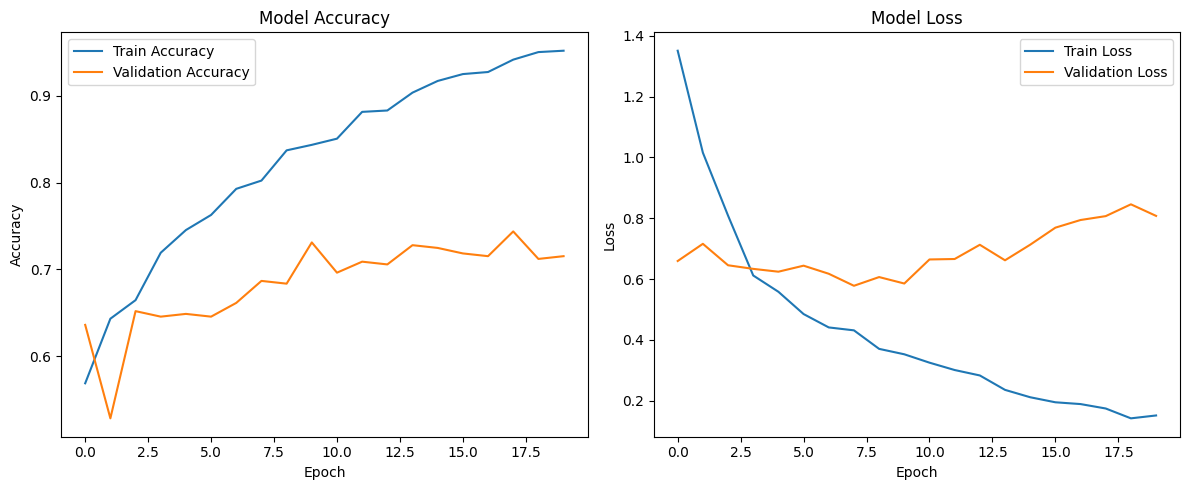


ROC AUC: 0.8224


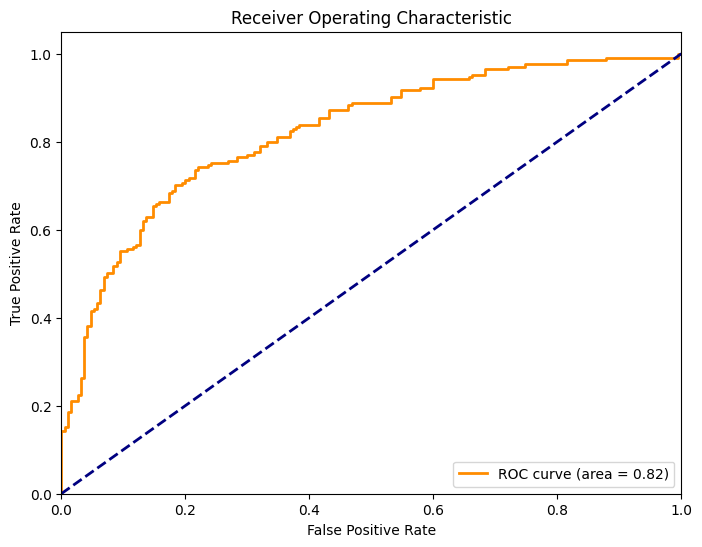

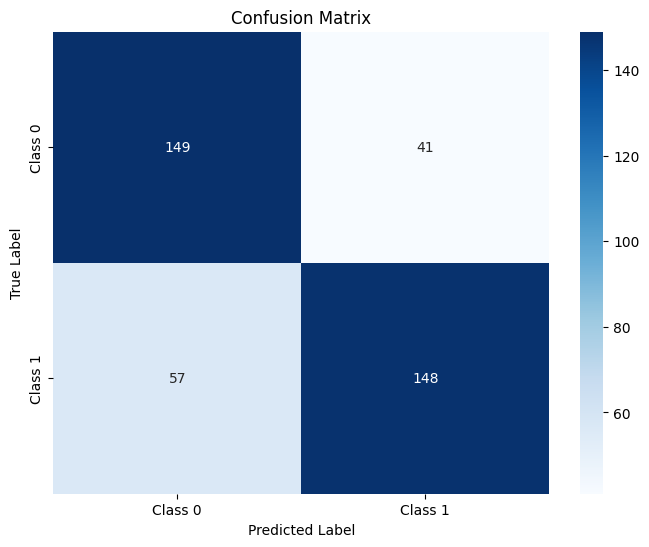

In [3]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(Xtest_reshaped, Ytest)
print(f"Test Accuracy: {accuracy:.2%}")
print(f"Test Loss: {loss:.4f}")
#--------------------------------------------------------------------------
Ypred = model.predict(Xtest_reshaped)
Ypred_classes = (Ypred > 0.5).astype(int)
Ypred_classes_flat = Ypred_classes.flatten()

# Print classification report (precision, recall, F1-score)
print("\nClassification Report:")
print(classification_report(Ytest, Ypred_classes_flat)) # Use Ytest directly
#-------------------------------------------------------------------------
# Plot accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
#------------------------------------------------------------------------
roc_auc = roc_auc_score(Ytest, Ypred[:, 0])
print(f"\nROC AUC: {roc_auc:.4f}")

# Plot ROC curve
# Use Ytest for true labels and Ypred[:, 0] for predicted probabilities of the positive class
fpr, tpr, thresholds = roc_curve(Ytest, Ypred[:, 0])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
#------------------------------------------------------------------------
cm = confusion_matrix(Ytest, Ypred_classes_flat)
plt.figure(figsize=(8, 6))
class_labels = ['Class 0', 'Class 1'] # Or provide your actual class names if available

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()